# 練習：Kerasで動かせるようにする（seq2seq）

## Import

In [1]:
from seq2seq.models import SimpleSeq2Seq
import numpy as np
import matplotlib.pylab as plt

Using TensorFlow backend.


## シンプルな Seq2Seq モデルを構築

In [2]:
model = SimpleSeq2Seq(input_dim=1, hidden_dim=10, output_length=8, output_dim=1)

## 学習の設定

In [3]:
model.compile(loss='mse', optimizer='rmsprop')

## データ作成

In [4]:
# 入力：1000パターンの位相を持つ一次元のサイン波
# 出力：各入力の逆位相のサイン波
a = np.random.random(1000)
x = np.array([np.sin([[p] for p in np.arange(0, 0.8, 0.1)] + aa) for aa in a])
y = -x

## 学習

In [5]:
model.fit(x, y, nb_epoch=5, batch_size=32)

/Users/szkhome/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/5
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5298
Epoch 2/5
1000/1000 [==============================] - 1s 893us/step - loss: 0.5001
Epoch 3/5
1000/1000 [==============================] - 1s 859us/step - loss: 0.4634
Epoch 4/5
1000/1000 [==============================] - 1s 869us/step - loss: 0.4158
Epoch 5/5
1000/1000 [==============================] - 1s 1ms/step - loss: 0.3567


## 未学習のデータでテスト

In [6]:
x_test = np.array([np.sin([[p] for p in np.arange(0, 0.8, 0.1)] + aa) for aa in np.arange(0, 1.0, 0.1)])
y_test = -x_test
print(model.evaluate(x_test, y_test, batch_size=32))

10/10 [==============================] - 0s 42ms/step
0.29976776242256165


## 未学習のデータで生成

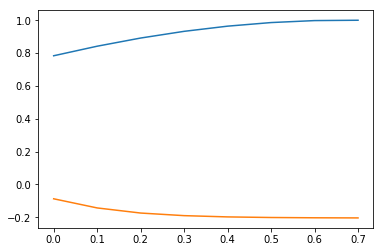

In [7]:
predicted = model.predict(x_test, batch_size=32)

plt.plot(np.arange(0, 0.8, 0.1), [xx[0] for xx in x_test[9]])
plt.plot(np.arange(0, 0.8, 0.1), [xx[0] for xx in predicted[9]])
plt.show()

# 本番：日付データセットをAttentionでやる
global attentionという言葉があり、このリンクが勉強になる。https://www.slideshare.net/yutakikuchi927/deep-learning-nlp-attention

## 日付データセットを用意する(世界中の日付の表し方trainとvalidationデータに)

In [16]:
import pandas as pd

# CSV ファイルを読み込み
train = pd.read_csv("./data/training.csv")
train.head(10)

,"12, sept 2010",2010-09-12
0,DISEMBA 14 1992,1992-12-14
1,8 JUN 1999,1999-06-08
2,11.03.00,2000-03-11
3,16 June 1979,1979-06-16
4,"лютага 1, 1988",1988-02-01
5,19.06.91,1991-06-19
6,12 јанвар 1981,1981-01-12
7,"30 Mpandula, 2015",2015-09-30
8,8 juil. 1996,1996-07-08
9,27 ژوئن 2017,2017-06-27


In [17]:
# CSV ファイルを読み込み
validation = pd.read_csv("./data/validation.csv")
validation.head(10)

,"22, XNT 2017",2017-07-22
0,13/5/1974,1974-05-13
1,sierpnia 10 1988,1988-08-10
2,14 mei 2002,2002-05-14
3,14 02 10,2010-02-14
4,06 Lush 2012,2012-08-06
5,"22, जून 1982",1982-06-22
6,02 Oct 1974,1974-10-02
7,1971年2月15日,1971-02-15
8,"23 ଅକ୍ଟୋବର, 1996",1996-10-23
9,March 21 1988,1988-03-21


## KerasでAttentionを実装する

In [21]:
import numpy as np
import os
from keras.models import Model
from keras.layers import Dense, Embedding, Activation, Permute
from keras.layers import Input, Flatten, Dropout
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed, Bidirectional
from models.custom_recurrents import AttentionDecoder #Attention 部分らしい


def simpleNMT(pad_length=100, #input sequenceの長さサイズ
              n_chars=105,#Vocabの中の文字の数
              n_labels=6,#可能性のあるラベリング種数
              embedding_learnable=False,
              encoder_units=256,
              decoder_units=256,
              trainable=True,
              return_probabilities=False):

    input_ = Input(shape=(pad_length,), dtype='float32')
    input_embed = Embedding(n_chars, n_chars,
                            input_length=pad_length,
                            trainable=embedding_learnable,
                            weights=[np.eye(n_chars)],
                            name='OneHot')(input_)

    rnn_encoded = Bidirectional(LSTM(encoder_units, return_sequences=True),
                                name='bidirectional_1',
                                merge_mode='concat',
                                trainable=trainable)(input_embed)

    y_hat = AttentionDecoder(decoder_units,
                             name='attention_decoder_1',
                             output_dim=n_labels,
                             return_probabilities=return_probabilities,
                             trainable=trainable)(rnn_encoded)

    model = Model(inputs=input_, outputs=y_hat)

    return model


if __name__ == '__main__':
    model = simpleNMT()
    model.summary()


inputs shape: (?, ?, 512)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_44 (InputLayer)        (None, 100)               0         
_________________________________________________________________
OneHot (Embedding)           (None, 100, 105)          11025     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 512)          741376    
_________________________________________________________________
attention_decoder_1 (Attenti (None, 100, 6)            928042    
Total params: 1,680,443
Trainable params: 1,669,418
Non-trainable params: 11,025
_________________________________________________________________


## 訓練する

In [23]:
import os
import argparse

from keras.callbacks import ModelCheckpoint

from models.NMT import simpleNMT
from data.reader import Data, Vocabulary
from utils.metrics import all_acc
from utils.examples import run_examples

In [26]:
cp = ModelCheckpoint("./weights/NMT.{epoch:02d}-{val_loss:.2f}.hdf5",
                     monitor='val_loss',
                     verbose=0,
                     save_best_only=True,
                     save_weights_only=True,
                     mode='auto')

# create a directory if it doesn't already exist
if not os.path.exists('./weights'):
    os.makedirs('./weights/')

In [35]:
# Dataset functions
input_vocab = Vocabulary('./data/human_vocab.json', padding=50)
output_vocab = Vocabulary('./data/machine_vocab.json', padding=50)



In [36]:
training_data='./data/training.csv'
validation_data='./data/validation.csv'


In [37]:

training = Data(training_data, input_vocab, output_vocab)
validation = Data(validation_data, input_vocab, output_vocab)
training.load()
validation.load()
training.transform()
validation.transform()
print('Datasets Loaded.')
print('Compiling Model.')

Datasets Loaded.
Compiling Model.


In [42]:
model = simpleNMT(pad_length=50,
                  n_chars=input_vocab.size(),
                  n_labels=output_vocab.size(),
                  embedding_learnable=False,
                  encoder_units=256,
                  decoder_units=256,
                  trainable=True,
                  return_probabilities=False)

model.summary()
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy', all_acc])
print('Model Compiled.')
print('Training. Ctrl+C to end early.')



inputs shape: (?, ?, 512)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_46 (InputLayer)        (None, 50)                0         
_________________________________________________________________
OneHot (Embedding)           (None, 50, 1367)          1868689   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 50, 512)           3325952   
_________________________________________________________________
attention_decoder_1 (Attenti (None, 50, 13)            938934    
Total params: 6,133,575
Trainable params: 4,264,886
Non-trainable params: 1,868,689
_________________________________________________________________
Model Compiled.
Training. Ctrl+C to end early.


In [43]:
model.fit_generator(generator=training.generator(32),
                    steps_per_epoch=100,
                    validation_data=validation.generator(32),
                    validation_steps=100,
                    callbacks=[cp],
                    workers=1,
                    verbose=1,
                    epochs=1)

Epoch 1/1
100/100 [==============================] - 4164s 42s/step - loss: 0.5454 - acc: 0.8362 - all_acc: 0.0000e+00 - val_loss: 0.3394 - val_acc: 0.8771 - val_all_acc: 0.0000e+00


In [ ]:
#時間がかかるため、１epochで終了とした